# Motivation
#### The role of data visualization is to give data scientists a new perspective on data they can use to form hypotheses and intuitively communicate information to customers. <br />
#### Therefore, we want to use this data to gain insights into the trends of incoming and outgoing traffic at various airports during the pandemic. By making each visualization dynamic we can explore individual points of interest within each visualizaiton or get a broad picture of the entire dataset.

In [1]:
import folium
import os

import datetime as dt
import geopandas as gpd
import geoplot as gplt
import ipywidgets as widgets
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from folium.plugins import MarkerCluster
from IPython.display import *
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import *

Visualization styling

In [2]:
sns.set_style('dark')
sns.set(rc = {
      'axes.edgecolor': '#242424'
    , 'axes.facecolor': '#242424'
    , 'axes.grid': False
    , 'axes.labelcolor': '#ffffff'
    , 'figure.facecolor': '#242424'
    , 'figure.figsize': (30, 20)
    , 'text.color': '#ffffff'
    , 'xtick.color': '#ffffff'
    , 'ytick.color': '#ffffff'
})

color_background = '#2e2e2e'
color_main = '#1c5a85'
color_highlight = '#94700f'
color_geo_highlight = '#5c5c5c'

Set working directory

In [3]:
os.chdir('D:/_DataSci/Projects/Covid Airport Traffic')

Read in Air Traffic dataset

In [4]:
df_traffic = pd.read_csv('covid_impact_on_airport_traffic.csv')

Convert dates and create numeric representations

In [5]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date'])
df_traffic['DateOrd'] = df_traffic['Date'].map(dt.datetime.toordinal)

Convert geo data

In [6]:
df_traffic['Centroid'] = gpd.GeoSeries.from_wkt(df_traffic['Centroid'])
df_traffic['Geography'] = gpd.GeoSeries.from_wkt(df_traffic['Geography'])

Assign a numeric value to each airport

In [7]:

keyed_names = np.sort(pd.unique(df_traffic['AirportName'].values))
df_traffic['AirportKey'] = df_traffic['AirportName'].map(lambda x: np.where(keyed_names == x)[0][0])

In [8]:
keyed_names

array(['Boston Logan International ', 'Calgary International',
       'Charlotte Douglas International', 'Chicago OHare International',
       'Dallas/Fort Worth International ',
       'Daniel K. Inouye International ', 'Denver International',
       'Detroit Metropolitan Wayne County ', 'Edmonton International',
       'Halifax International', 'Hamilton International',
       'Hartsfield-Jackson Atlanta International ',
       'John F. Kennedy International', 'Kingsford Smith', 'LaGuardia',
       'Los Angeles International', 'McCarran International',
       'Miami International ', 'Montreal Mirabel', 'Montreal Trudeau',
       'Newark Liberty International ', 'San Francisco International',
       'Santiago International Airport', 'Seattle-Tacoma International ',
       'Toronto Pearson', 'Vancouver International',
       'Washington Dulles International ', 'Winnipeg International'],
      dtype=object)

In [9]:
df_traffic.shape, df_traffic.dtypes

((7247, 13),
 AggregationMethod            object
 Date                 datetime64[ns]
 Version                     float64
 AirportName                  object
 PercentOfBaseline             int64
 Centroid                   geometry
 City                         object
 State                        object
 ISO_3166_2                   object
 Country                      object
 Geography                  geometry
 DateOrd                       int64
 AirportKey                    int64
 dtype: object)

In [10]:
df_traffic.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography,DateOrd,AirportKey
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT (151.18009 -33.94598),Sydney,New South Wales,AU,Australia,"POLYGON ((151.16435 -33.93018, 151.16332 -33.9...",737518,13
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT (151.18009 -33.94598),Sydney,New South Wales,AU,Australia,"POLYGON ((151.16435 -33.93018, 151.16332 -33.9...",737528,13
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT (151.18009 -33.94598),Sydney,New South Wales,AU,Australia,"POLYGON ((151.16435 -33.93018, 151.16332 -33.9...",737616,13
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT (151.18009 -33.94598),Sydney,New South Wales,AU,Australia,"POLYGON ((151.16435 -33.93018, 151.16332 -33.9...",737670,13
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT (151.18009 -33.94598),Sydney,New South Wales,AU,Australia,"POLYGON ((151.16435 -33.93018, 151.16332 -33.9...",737729,13


# Timeline Information
#### There were a handful of airports I wanted to look at with a little more scrutiny to see if how directly state and country policies affected their traffic capacity. These will be:
+ John F. Kenedy International (Queens, New York)
+ LaGuardia (Queens, New York)
+ Newark Liberty International (Newark, New Jersey)
+ McCarran International (Paradise, Nevada)
+ Kingsford Smith (Sydney, Australia)
+ Santiago International (Santiago, Chile)

#### For this I gathered information about national and state policies that were implemented during the time of the data. I could then plot them alongside the data to see if there was any obvious differntiation in the trend.

In [11]:
df_sources = pd.DataFrame(
    [
          [0, 'Chile Ministry of Communications', 'n.d.', 'Plan update "Step by Step"', 'https://www.gob.cl/coronavirus/pasoapaso/']
        , [1, 'Federal Register', '31 Jan 2020', 'Suspension of Entry as Immigrants and Nonimmigrants of Persons Who Pose a Risk of Transmitting 2019 Novel Coronavirus and Other Appropriate Measures To Address This Risk', 'https://www.federalregister.gov/documents/2020/02/05/2020-02424/suspension-of-entry-as-immigrants-and-nonimmigrants-of-persons-who-pose-a-risk-of-transmitting-2019']
        , [2, 'Federal Register', '11 Mar 2020', 'Suspension of Entry as Immigrants and Nonimmigrants of Certain Additional Persons Who Pose a Risk of Transmitting 2019 Novel Coronavirus', 'https://www.federalregister.gov/documents/2020/03/16/2020-05578/suspension-of-entry-as-immigrants-and-nonimmigrants-of-certain-additional-persons-who-pose-a-risk-of']
        , [3, 'Johnson, T', '29 June 2020', 'Addendum 2 to April 21, 2020 Policy Memorandum', 'https://gaming.nv.gov/modules/showdocument.aspx?documentid=16863']
        , [4, 'New South Wales Government', '10 May 2020', 'NSW to ease COVID-19 restrictions from Friday 15 May', 'https://www.nsw.gov.au/news/nsw-to-ease-covid-19-restrictions-from-friday-15-may']
        , [5, 'New South Wales Government', '1 June 2020', 'New COVID-19 restrictions in place across NSW', 'https://www.nsw.gov.au/news/new-covid-19-restrictions-place-across-nsw']
        , [6, 'New South Wales Government Health', '18 Mar 2020', 'COVID-19 update', 'https://www.health.nsw.gov.au/news/Pages/20200318_01.aspx']
        , [7, 'New York Govenor Press Office', '24 June 2020', 'Governor Cuomo, Governor Murphy and Governor Lamont Announce Joint Incoming Travel Advisory That All Individuals Traveling from States with Significant Community Spread of COVID-19 Quarantine for 14 Days', 'https://www.governor.ny.gov/news/governor-cuomo-governor-murphy-and-governor-lamont-announce-joint-incoming-travel-advisory-all']
        , [8, 'New York Govenor Press Office', '28 July 2020', 'Governor Cuomo Announces Individuals Traveling to New York From Three Additional States, Puerto Rico and Washington D.C. Will Be Required to Quarantine for 14 Days', 'https://www.governor.ny.gov/news/governor-cuomo-announces-individuals-traveling-new-york-three-additional-states-puerto-rico-and']
        , [9, 'New York Govenor Press Office', '25 Aug 2020', 'Governor Cuomo Announces Five States Removed from COVID-19 Travel Advisory Requiring 14-Day Quarantines', 'https://www.governor.ny.gov/news/governor-cuomo-announces-five-states-removed-covid-19-travel-advisory-requiring-14-day']
        , [10, 'New York Govenor Press Office', '22 Sep 2020', 'Governor Cuomo Announces Five States Added to Travel Advisory and 10 Million COVID-19 Diagnostic Tests Conducted', 'https://www.governor.ny.gov/news/governor-cuomo-announces-five-states-added-travel-advisory-and-10-million-covid-19-diagnostic']
        , [11, 'New York Govenor Press Office', '31 Oct 2020', 'Governor Cuomo Announces New Guidelines Allowing Out-of-State Travelers to "Test Out" of Mandatory 14-Day Quarantine', 'https://www.governor.ny.gov/news/governor-cuomo-announces-new-guidelines-allowing-out-state-travelers-test-out-mandatory-14-day']
        , [12, 'Sisolak, S', '17 Mar 2020', 'Declaration of Emergency Directive 002', 'https://nvhealthresponse.nv.gov/wp-content/uploads/2020/04/2020-03-18.Declaration-of-Emergency-Directive-002-re-Closing-Casinos.pdf']
        , [13, 'Sisolak, S', '1 Apr 2020', 'Declaration of Emergency Directive 009 (Revised)', 'https://nvhealthresponse.nv.gov/wp-content/uploads/2020/05/Directive-009-Revised.pdf']
        , [14, 'Sisolak, S', '7 May 2020', 'Declaration of Emergency Directive 018', 'https://gov.nv.gov/News/Emergency_Orders/2020/2020-05-07_-_COVID-19_Declaration_of_Emergency_Directive_018_-_Phase_One_Reopening_(Attachments)/']
        , [15, 'Sisolak, S', '14 Aug 2020', 'Declaration of Emergency Directive 030', 'https://nvhealthresponse.nv.gov/wp-content/uploads/2020/08/2020-08-14.Declaration-of-Emergency-Directive-030.pdf']
        , [16, 'Sisolak, S', '30 Sep 2020', 'Declaration of Emergency Directive 033', 'https://gov.nv.gov/News/Emergency_Orders/2020/2020-09-11_-_COVID-19_Declaration_of_Emergency_Directive_032/']
        , [17, 'Statista', 'n.d.', 'Monthly number of passenger visitors at Sydney Airport in Australia from February 2019 to October 2021, by passenger type', 'https://www.statista.com/statistics/1107414/australia-sydney-airport-traffic-by-passenger-type/']
        , [18, 'U.S. Embassy in Chile', '16 Mar 2020', 'Health Alert - U.S. Embassy Santiago, Chile', 'https://cl.usembassy.gov/health-alert-u-s-embassy-santiago-chile/']
        , [19, 'U.S. Embassy in Chile', '12 Aug 2020', 'Health Alert - U.S. Embassy Santiago - Covid-19 Update (08/12/2020)', 'https://cl.usembassy.gov/health%e2%80%afalert-u-s-embassy-santiago-covid-19-update-08-12-2020/']

    ]
    , columns = ['Id', 'Author', 'Date', 'Title', 'Link']
)

In [12]:
df_timeline = pd.DataFrame(
    [
          [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from China (Feb 2)', 1, 12]
        , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from China (Feb 2)', 1, 14]
        # , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from China (Feb 2)', 1, 16]
        , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from China (Feb 2)', 1, 20]
        , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from most of Europe (Mar 11)', 2, 12]
        , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from most of Europe (Mar 11)', 2, 14]
        # , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from most of Europe (Mar 11)', 2, 16]
        , [pd.to_datetime('2020-03-16'), 'Travel into the US restricted from most of Europe (Mar 11)', 2, 20]
        , [pd.to_datetime('2020-03-18'), 'NSW restricts non-essential travel', 6, 13]
        , [pd.to_datetime('2020-03-18'), 'Chilean government restricts all foriegn entry into Chile', 18, 22]
        , [pd.to_datetime('2020-03-18'), 'All non-essential business, to include the Las Vegas strip, closed for 30 days', 12, 16]
        , [pd.to_datetime('2020-04-01'), 'Closures for non-essential businesses extened', 13, 16]
        , [pd.to_datetime('2020-05-07'), 'Non-essential businesses allowed to operate at limited capacities', 14, 16]
        , [pd.to_datetime('2020-05-10'), 'General covid restrictions loosened', 4, 13]
        , [pd.to_datetime('2020-06-01'), 'Additional restrictions loosened, to include allowing regional holiday travel', 5, 13]
        , [pd.to_datetime('2020-06-04'), 'Casinos able to operate with limited capacity', 3, 16]
        , [pd.to_datetime('2020-06-24'), '14 day quarantine is required from travelers from 9 states that exceed a 10% infection rate', 7, 12]
        , [pd.to_datetime('2020-06-24'), '14 day quarantine is required from travelers from 9 states that exceed a 10% infection rate', 7, 14]
        , [pd.to_datetime('2020-06-24'), '14 day quarantine is required from travelers from 9 states that exceed a 10% infection rate', 7, 20]
        , [pd.to_datetime('2020-07-18'), 'Introduction of "Paso a Paso nos cuidamos", a tiered quarantining process', 0, 22]
        , [pd.to_datetime('2020-07-22'), '* Drastic drop seems to be from the combination of low international and local traffic', 17, 13]
        , [pd.to_datetime('2020-07-28'), 'Tri-state quarantine requirement is adjusted', 8, 12]
        , [pd.to_datetime('2020-07-28'), 'Tri-state quarantine requirement is adjusted', 8, 14]
        , [pd.to_datetime('2020-07-28'), 'Tri-state quarantine requirement is adjusted', 8, 20]
        , [pd.to_datetime('2020-08-14'), 'Govenor adopts new means of tackling outbreaks and moves away from prior phased re-opening plan', 15, 16]
        , [pd.to_datetime('2020-08-18'), 'Santiago quarantine lifted (Aug 16, day missing from data)', 19, 22]
        , [pd.to_datetime('2020-08-25'), 'Tri-state quarantine requirement is adjusted', 9, 12]
        , [pd.to_datetime('2020-08-25'), 'Tri-state quarantine requirement is adjusted', 9, 14]
        , [pd.to_datetime('2020-08-25'), 'Tri-state quarantine requirement is adjusted', 9, 20]
        , [pd.to_datetime('2020-09-22'), 'Tri-state quarantine requirement is adjusted', 10, 12]
        , [pd.to_datetime('2020-09-22'), 'Tri-state quarantine requirement is adjusted', 10, 14]
        , [pd.to_datetime('2020-09-22'), 'Tri-state quarantine requirement is adjusted', 10, 20]
        , [pd.to_datetime('2020-09-30'), 'Capacity limitations increased for public venues', 16, 16]
        , [pd.to_datetime('2020-10-31'), 'Out of state travelers required to quarantine for a minimum of 3 days or until they receive a negative covid test', 11, 12]
        , [pd.to_datetime('2020-10-31'), 'Out of state travelers required to quarantine for a minimum of 3 days or until they receive a negative covid test', 11, 14]
        , [pd.to_datetime('2020-10-31'), 'Out of state travelers required to quarantine for a minimum of 3 days or until they receive a negative covid test', 11, 20]
    ]
    , columns = ['Date', 'Event', 'SourceId', 'Airport']
)

df_timeline.head()

,Date,Event,SourceId,Airport
0,2020-03-16,Travel into the US restricted from China (Feb 2),1,12
1,2020-03-16,Travel into the US restricted from China (Feb 2),1,14
2,2020-03-16,Travel into the US restricted from China (Feb 2),1,20
3,2020-03-16,Travel into the US restricted from most of Eur...,2,12
4,2020-03-16,Travel into the US restricted from most of Eur...,2,14


# Functions
#### I implemented a dynamic method of building plots that would allow each element of the plot to be chosen individually and layered by user preference. <br />
#### Additionally each plot can be subset by a range of dates allowing you to zoom into the data where you find interest.

Plot a horizontal line at the average percent of the given subset

In [13]:
def avg_line(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    ax.hlines(
          xmin = props['xmin']
        , xmax = props['date_max'] + 5
        , y = props['mean']
        , color = color_highlight
        , linewidth = 6
        , zorder = zorder
    )

Plot the average percent of the given subset

In [14]:
def avg_text(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    ax.text(
          x = props['xmin']
        , y = props['mean']
        , s = f'{props["mean"]}%'
        , color = color_highlight
        , fontsize = 48
        , va = 'bottom'
        , weight = 'bold'
        , zorder = zorder
    )

IPython widget to allow subsetting the data by a range of dates

In [15]:
def date_slider() -> widgets.SelectionRangeSlider:
    dates = np.sort(pd.unique(df_traffic['Date']))
    return widgets.SelectionRangeSlider(
          options = [f' {str(d)[5:10]} ' for d in dates]
        , index = (0, dates.size - 1)
        , description = "Dates"
        , layout = {
            'width': '1000px'
        }
    )

Plot a series of vertical lines corresponding to the events within the timeline of the given subset

In [16]:
def event_lines(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    events = df.query(f'AirportKey == {props["airport"]}').merge(df_timeline.query(f'Airport == {props["airport"]}'), how = 'inner', on = 'Date')
    for _, row in events.iterrows():
        ax.vlines(
              x = row['DateOrd']
            , ymin = props['ymin']
            , ymax = props['ymax']
            , color = color_background
            , linestyle = ':'
            , linewidth = 5
            , zorder = zorder
        )

Plot a series of descriptions of events within the corresponding timeline of the given subset

In [17]:
def event_text(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    events = df.query(f'AirportKey == {props["airport"]}').merge(df_timeline.query(f'Airport == {props["airport"]}'), how = 'inner', on = 'Date')
    for i, row in events.iterrows():
        ax.text(
              x = row['DateOrd']
            , y = (i % 2) * -10
            , s = f'[{int(row["SourceId"])}] {wrap_text(row["Event"])}'
            , color = color_highlight
            , fontsize = 16
            , va = 'bottom'
            , weight = 'bold'
            , wrap = True
            , zorder = zorder
        )

Plot the geo data of the given subset

In [18]:
def geo_vis(dates: tuple[str, str]) -> folium.Map:
    df = df_traffic.query(f'"2020-{dates[0]}" <= Date <= "2020-{dates[1]}"')
    
    map_world = folium.Map(tiles = 'cartodbdark_matter', zoom_start = 5)
    map_cluster = MarkerCluster().add_to(map_world)
    
    for airport, data in df.groupby('AirportName'):
        point = data['Centroid'].values[0]
        prcnt = round(data['PercentOfBaseline'].mean())
        
        folium.Marker(
              location = [point.y, point.x]
            , icon = folium.DivIcon(html = f'''
                <div style="color: #fff; font-family: sans-serif; font-size: 25px; font-weight: 700">
                    {prcnt}%
                </div>'''
            )
            , tooltip = airport
        ).add_to(map_cluster)
        
        folium.GeoJson(
              data = data['Geography'].values[0]
            , style_function =  lambda _: {'fillColor': color_geo_highlight}
            , tooltip = airport
        ).add_to(map_world)

    return map_world

Plot the polynomial regression of the given subset, allows easy visualization of the overall trend

In [19]:
def poly_reg(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    poly_x = df.iloc[:, 11:12] # EWW
    poly_y = df['PercentOfBaseline']
    
    poly = PolynomialFeatures(degree = 5)
    lin = LinearRegression()
    lin.fit(poly.fit_transform(poly_x), poly_y)
    
    plt.plot(
          poly_x
        , lin.predict(poly.fit_transform(poly_x))
        , color = color_background
        , linewidth = 60
        , zorder = zorder
    )

Plot the traffic capacity by date of the given subset

In [20]:
def traffic_line(df: pd.DataFrame, ax: plt.SubplotTool, props: dict, zorder: int) -> None:
    sns.lineplot(
          x = 'DateOrd'
        , y = 'PercentOfBaseline'
        , data = df
        , ax = ax
        , color = color_main
        , legend = False
        , linewidth = 6
        , zorder = zorder
    )

Create a line graph of Baseline Percent by Date of the specified airport for the given subset

In [21]:
def graph_percent(airport: int, dates: tuple[str, str], funcs: List[Callable]) -> None:
    df = df_traffic.query(f'AirportKey == {airport} & "2020-{dates[0]}" <= Date <= "2020-{dates[1]}"').sort_values(by = ['Date'])
    props = {
          'airport': airport
        , 'date_min': df['DateOrd'].min()
        , 'date_max': df['DateOrd'].max()
        , 'mean': round(df['PercentOfBaseline'].mean())
        , 'xmin': df['DateOrd'].min() - 20
        , 'xmax': df['DateOrd'].max() + 20
        , 'ymin': -15
        , 'ymax': 110
    }
    
    ax = plt.subplot()
    ax.set(
          xlim = (props['xmin'], props['xmax'])
        , xlabel = "Dates"
        , ylim = (props['ymin'], props['ymax'])
        , ylabel = "Percent Of Baseline"
    )
    ax.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(MaxNLocator(nbins = df.shape[0] * (15 * (1 / df.shape[0]))))
    
    for z, func in enumerate(funcs):
        func(df, ax, props, z)

    plt.title(
          df['AirportName'].values[0]
        , fontdict = {
            'fontsize': 30
        }
    )
    
    # ax.set_xticks([dt.datetime.fromordinal(int(t)) for t in ax.get_xticks()])
    
    plt.show()

Wrap text after the specified number of words

In [22]:
def wrap_text(s: str, width: int = 3) -> str:
    return ''.join([word + (' ' if (i + 1) % width else '\n') for i, word in enumerate(s.split())])

# Geo Visualization
#### This gives us a very high level view of the overall traffic capacity for each airport over the timeline of the dataset. <br />
#### The date range can be altered for a more specific timeline.

In [23]:
widgets.interact(geo_vis, dates = date_slider())

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

<function __main__.geo_vis(dates: tuple) -> folium.folium.Map>

# Detailed Line Graphs for the Airports of Interest
+ I wanted to look at the New York and New Jersey airports because New York had some of the highest numbers for Covid-19 along with some of the strictest guidelines. In addition they entered a Tri-State agreement with New Jersey and Conneticut to restrict out of state travel. While the list of restricted states was updated weekly, for the sake of visual clarity, I limited notations of this to a monthly basis.
+ McCarran had both low numbers and seemed to have the most impact from local policy, as these policies closed the Las Vegas strip. I also omitted the U.S. travel restrictions from China and Europe from its graph for visual clarity.
+ Kingsford Smith had quite low traffic and a very drastic change in traffic compared to most airports. However, information in general for Australia's Covid policies was difficult to find for 2020 past June and there didn't seem to be any direction from their government or the airport itself that really correlated with the decrease. It's possible this is just an anomoly of the baseline period.
+ Santiago International had quite low traffic which likely seems explained by the countries travel restrictions. However, it seems intuitive that developing countries would be disproportionately affected by decreased travel in general.

In [24]:
for key in [12, 13, 14, 16, 20, 22]:
    widgets.interact(
          graph_percent
        , dates = date_slider()
        , airport = widgets.fixed(key)
        , funcs = widgets.fixed([poly_reg, event_lines, avg_line, traffic_line, avg_text, event_text])
    )

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

# General Line Graphs
#### Line graphs for each airport, timeline of events ommitted.

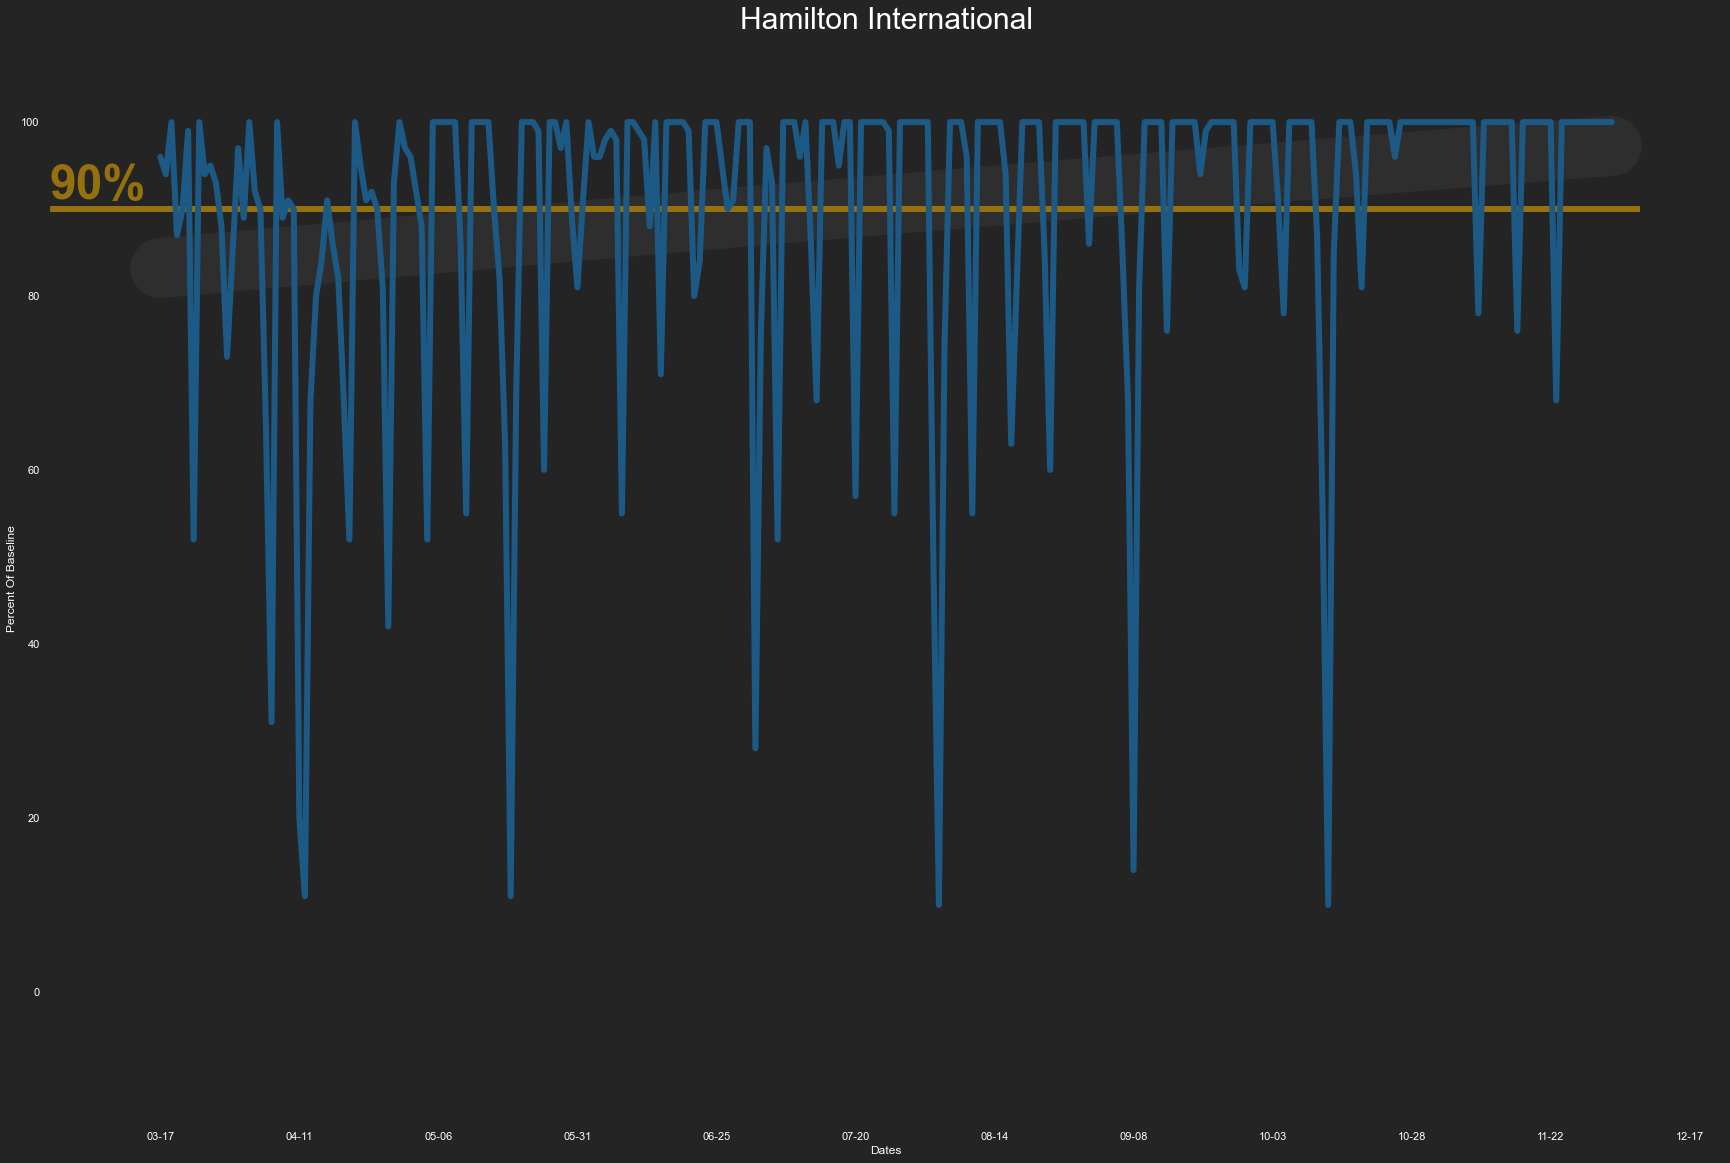

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 261), layout=Layout(width='1000px'),…

In [25]:
for key in range(len(keyed_names)):
    widgets.interact(
          graph_percent
        , dates = date_slider()
        , airport = widgets.fixed(key)
        , funcs = widgets.fixed([poly_reg, avg_line, traffic_line, avg_text])
    )

# Sources

In [26]:
display(Markdown('<br /><br />'.join([f'[{row["Id"]}] {row["Author"]}. ({row["Date"]}). {row["Title"]}.<br />&emsp;{row["Link"]}' for _, row in df_sources.iterrows()])))

[0] Chile Ministry of Communications. (n.d.). Plan update "Step by Step".<br />&emsp;https://www.gob.cl/coronavirus/pasoapaso/<br /><br />[1] Federal Register. (31 Jan 2020). Suspension of Entry as Immigrants and Nonimmigrants of Persons Who Pose a Risk of Transmitting 2019 Novel Coronavirus and Other Appropriate Measures To Address This Risk.<br />&emsp;https://www.federalregister.gov/documents/2020/02/05/2020-02424/suspension-of-entry-as-immigrants-and-nonimmigrants-of-persons-who-pose-a-risk-of-transmitting-2019<br /><br />[2] Federal Register. (11 Mar 2020). Suspension of Entry as Immigrants and Nonimmigrants of Certain Additional Persons Who Pose a Risk of Transmitting 2019 Novel Coronavirus.<br />&emsp;https://www.federalregister.gov/documents/2020/03/16/2020-05578/suspension-of-entry-as-immigrants-and-nonimmigrants-of-certain-additional-persons-who-pose-a-risk-of<br /><br />[3] Johnson, T. (29 June 2020). Addendum 2 to April 21, 2020 Policy Memorandum.<br />&emsp;https://gaming.nv.gov/modules/showdocument.aspx?documentid=16863<br /><br />[4] New South Wales Government. (10 May 2020). NSW to ease COVID-19 restrictions from Friday 15 May.<br />&emsp;https://www.nsw.gov.au/news/nsw-to-ease-covid-19-restrictions-from-friday-15-may<br /><br />[5] New South Wales Government. (1 June 2020). New COVID-19 restrictions in place across NSW.<br />&emsp;https://www.nsw.gov.au/news/new-covid-19-restrictions-place-across-nsw<br /><br />[6] New South Wales Government Health. (18 Mar 2020). COVID-19 update.<br />&emsp;https://www.health.nsw.gov.au/news/Pages/20200318_01.aspx<br /><br />[7] New York Govenor Press Office. (24 June 2020). Governor Cuomo, Governor Murphy and Governor Lamont Announce Joint Incoming Travel Advisory That All Individuals Traveling from States with Significant Community Spread of COVID-19 Quarantine for 14 Days.<br />&emsp;https://www.governor.ny.gov/news/governor-cuomo-governor-murphy-and-governor-lamont-announce-joint-incoming-travel-advisory-all<br /><br />[8] New York Govenor Press Office. (28 July 2020). Governor Cuomo Announces Individuals Traveling to New York From Three Additional States, Puerto Rico and Washington D.C. Will Be Required to Quarantine for 14 Days.<br />&emsp;https://www.governor.ny.gov/news/governor-cuomo-announces-individuals-traveling-new-york-three-additional-states-puerto-rico-and<br /><br />[9] New York Govenor Press Office. (25 Aug 2020). Governor Cuomo Announces Five States Removed from COVID-19 Travel Advisory Requiring 14-Day Quarantines.<br />&emsp;https://www.governor.ny.gov/news/governor-cuomo-announces-five-states-removed-covid-19-travel-advisory-requiring-14-day<br /><br />[10] New York Govenor Press Office. (22 Sep 2020). Governor Cuomo Announces Five States Added to Travel Advisory and 10 Million COVID-19 Diagnostic Tests Conducted.<br />&emsp;https://www.governor.ny.gov/news/governor-cuomo-announces-five-states-added-travel-advisory-and-10-million-covid-19-diagnostic<br /><br />[11] New York Govenor Press Office. (31 Oct 2020). Governor Cuomo Announces New Guidelines Allowing Out-of-State Travelers to "Test Out" of Mandatory 14-Day Quarantine.<br />&emsp;https://www.governor.ny.gov/news/governor-cuomo-announces-new-guidelines-allowing-out-state-travelers-test-out-mandatory-14-day<br /><br />[12] Sisolak, S. (17 Mar 2020). Declaration of Emergency Directive 002.<br />&emsp;https://nvhealthresponse.nv.gov/wp-content/uploads/2020/04/2020-03-18.Declaration-of-Emergency-Directive-002-re-Closing-Casinos.pdf<br /><br />[13] Sisolak, S. (1 Apr 2020). Declaration of Emergency Directive 009 (Revised).<br />&emsp;https://nvhealthresponse.nv.gov/wp-content/uploads/2020/05/Directive-009-Revised.pdf<br /><br />[14] Sisolak, S. (7 May 2020). Declaration of Emergency Directive 018.<br />&emsp;https://gov.nv.gov/News/Emergency_Orders/2020/2020-05-07_-_COVID-19_Declaration_of_Emergency_Directive_018_-_Phase_One_Reopening_(Attachments)/<br /><br />[15] Sisolak, S. (14 Aug 2020). Declaration of Emergency Directive 030.<br />&emsp;https://nvhealthresponse.nv.gov/wp-content/uploads/2020/08/2020-08-14.Declaration-of-Emergency-Directive-030.pdf<br /><br />[16] Sisolak, S. (30 Sep 2020). Declaration of Emergency Directive 033.<br />&emsp;https://gov.nv.gov/News/Emergency_Orders/2020/2020-09-11_-_COVID-19_Declaration_of_Emergency_Directive_032/<br /><br />[17] Statista. (n.d.). Monthly number of passenger visitors at Sydney Airport in Australia from February 2019 to October 2021, by passenger type.<br />&emsp;https://www.statista.com/statistics/1107414/australia-sydney-airport-traffic-by-passenger-type/<br /><br />[18] U.S. Embassy in Chile. (16 Mar 2020). Health Alert - U.S. Embassy Santiago, Chile.<br />&emsp;https://cl.usembassy.gov/health-alert-u-s-embassy-santiago-chile/<br /><br />[19] U.S. Embassy in Chile. (12 Aug 2020). Health Alert - U.S. Embassy Santiago - Covid-19 Update (08/12/2020).<br />&emsp;https://cl.usembassy.gov/health%e2%80%afalert-u-s-embassy-santiago-covid-19-update-08-12-2020/